In [1]:
import gymnasium
import skyscraper
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

In [2]:
env = gymnasium.make('skyscraper/GridWorld-v0')

In [3]:
model_M = {}

with open('powered_flight.txt', 'r') as file:
    for line in file:
        i, j, a, r, i_prime, j_prime = map(int, line.split())
        # adjusting for 0-indexing
        i, j, a, i_prime, j_prime = i - 1, j - 1, a - 1, i_prime - 1, j_prime - 1

        # key: current state and action, value: reward and next state
        model_M[((i, j), a)] = (r, (i_prime, j_prime))

In [4]:
def random_argmax(arr):
    max_value = np.max(arr)
    max_indices = np.where(arr == max_value)[0]
    random_index = random.choice(max_indices)
    return random_index

In [5]:
def eps_greedy_policy(Q, epsilon, action_space):
    # define an epsilon-greedy policy function based on Q table
    def policy_func(state):
        # initialize a uniform distribution for all actions with a bias of epsilon
        prob_distribution = np.ones(action_space) * epsilon / action_space
        # use random_argmax to choose action with the highest Q value (with ties broken arbitrarily)
        best_action = random_argmax(Q[state])
        # increase probability of taking the best action by 1 - epsilon
        prob_distribution[best_action] += (1 - epsilon)
        return prob_distribution

    return policy_func

In [6]:
def get_pos(state):
    return tuple(map(int, state['agent']['pos']))

In [7]:
def dyna_q(env, model, n, num_episodes=500, epsilon_start=0.7, epsilon_decay=0.999, epsilon_min=0.1,
           alpha=0.1, gamma=0.99, env_height=32, env_width=64):
    # initialize Q(s, a) with zeros for all state-action pairs
    Q = np.zeros((env_height, env_width, env.action_space.n))

    # initialize policy using epsilon-greedy method
    epsilon = epsilon_start
    policy = eps_greedy_policy(Q, epsilon, env.action_space.n)

    stats = {"episode_length": [],
             "episode_crashes": []}

    for episode in range(1, num_episodes + 1):
        if episode % 100 == 0:
            print(f"\rEpisode {episode}/{num_episodes}.", end="")

        episode_length = 0
        episode_crashes = 0

        state, _ = env.reset()

        while True:
            probs = policy(get_pos(state))
            # choose A from S using eps-greedy policy derived from Q
            action = np.random.choice(np.arange(len(probs)), p=probs)

            # take action A; observe resultant reward R, and state, S'
            next_state, reward, done, crashed, _ = env.step(action)

            # Q-learning: update Q-value for the current state and action
            best_next_action = np.argmax(Q[get_pos(next_state)])
            td_target = reward + gamma * Q[get_pos(next_state)][best_next_action]
            td_delta = td_target - Q[get_pos(state)][action]
            Q[get_pos(state)][action] += alpha * td_delta

            # Model Update: update the model with the new experience
            model[(get_pos(state), action)] = (reward, get_pos(next_state))

            # Planning Step: update Q-values using simulated experiences from the model
            for _ in range(n):
                # randomly select state and action previously observed
                sim_state, sim_action = list(model.keys())[np.random.choice(len(model.keys()))]
                sim_reward, sim_next_state = model[(sim_state, sim_action)]

                # update Q-values as if the selected s, a, r, s_prime were a real experience
                best_sim_next_action = np.argmax(Q[sim_next_state])
                sim_td_target = sim_reward + gamma * Q[sim_next_state][best_sim_next_action]
                sim_td_delta = sim_td_target - Q[sim_state][sim_action]
                Q[sim_state][sim_action] += alpha * sim_td_delta

            episode_length += 1

            # crashed
            if crashed:
                episode_crashes += 1

            # terminated
            if done:
                stats["episode_length"].append(episode_length)
                stats["episode_crashes"].append(episode_crashes)
                break  # exit loop if agent has reached target

            state = next_state

        epsilon = max(epsilon_min, epsilon_decay * epsilon)
        policy = eps_greedy_policy(Q, epsilon, env.action_space.n)

    return policy, stats

In [9]:
policy_5, stats_5 = dyna_q(env, model_M, n=5)

Episode 500/500.

In [10]:
policy_10, stats_10 = dyna_q(env, model_M, n=10)

Episode 500/500.

In [15]:
policy_20, stats_20 = dyna_q(env, model_M, n=20)

Episode 500/500.

In [ ]:
policy_40, stats_40 = dyna_q(env, model_M, n=40)

In [11]:
def get_trajectory(env, policy):
    state, _ = env.reset()
    trajectory = [get_pos(state)]

    while True:
        action = np.argmax(policy(get_pos(state)))
        state, reward, done, _, _ = env.step(action)
        trajectory.append(get_pos(state))

        if done:
            break
    return trajectory

In [51]:
def plot_trajectory(env, trajectory, n_simulations):
    skyscraper_map = env.unwrapped.MAP
    rows, cols = zip(*trajectory)

    plt.figure(figsize=(8, 4))
    plt.imshow(skyscraper_map, cmap="Greys_r")
    plt.plot(cols, rows, color="steelblue", linewidth=1, marker='.', markersize=5)

    grid_height, grid_width = skyscraper_map.shape
    plt.xticks(np.arange(-0.5, grid_width, 1), minor=True)
    plt.yticks(np.arange(-0.5, grid_height, 1), minor=True)

    plt.grid(which="minor", color="slategrey", linestyle=':', linewidth=0.5)

    start_state = (13, 5)
    plt.scatter(start_state[1], start_state[0], s=35, c='indianred', marker='o', label='Start')

    end_state = (14, 54)
    plt.scatter(end_state[1], end_state[0], s=35, c='seagreen', marker='s', label='End')

    plt.title(f"Flight Trajectory with {n_simulations} Planning Steps")
    plt.legend()
    plt.show()

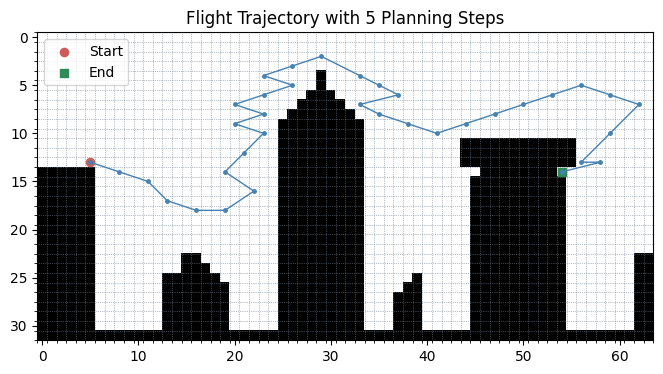

In [52]:
trajectory_5 = get_trajectory(env, policy_5)
plot_trajectory(env, trajectory_5, n_simulations=5)

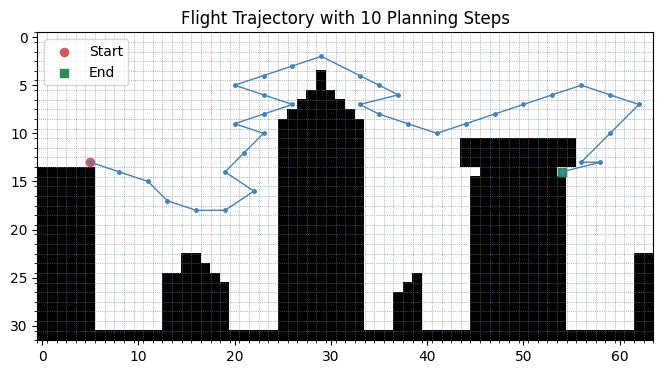

In [53]:
trajectory_10 = get_trajectory(env, policy_10)
plot_trajectory(env, trajectory_10, n_simulations=10)

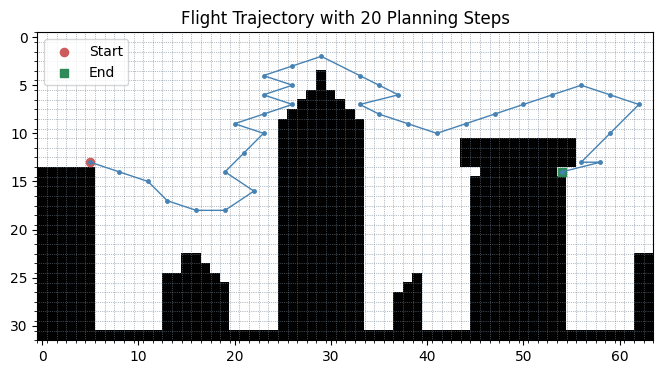

In [54]:
trajectory_20 = get_trajectory(env, policy_20)
plot_trajectory(env, trajectory_20, n_simulations=20)

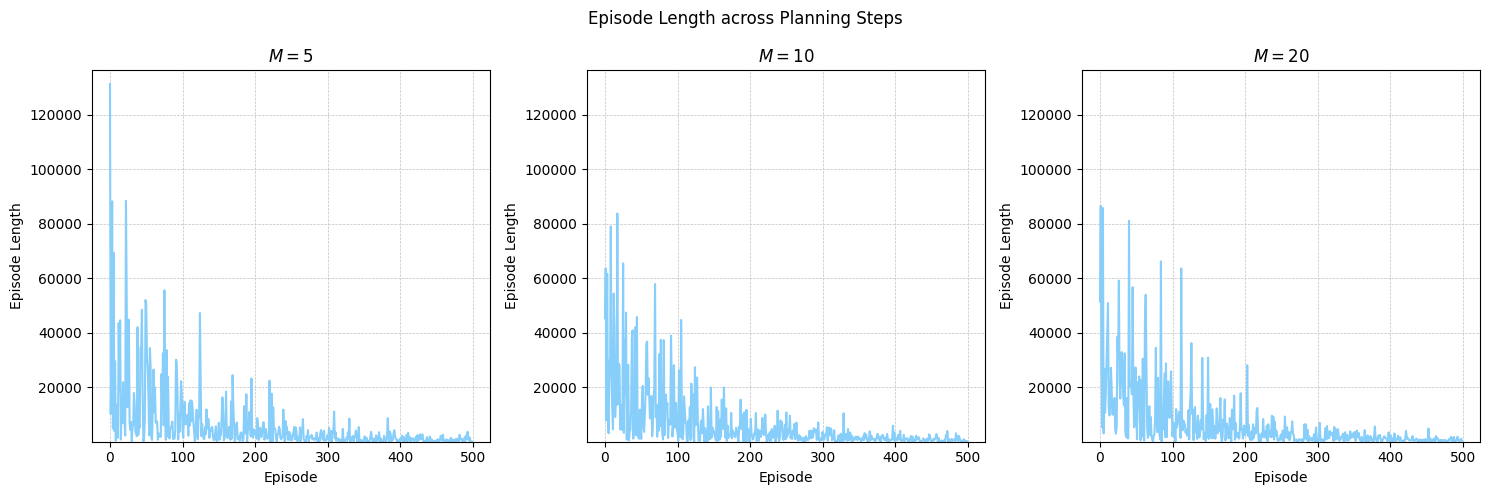

In [55]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Episode Length across Planning Steps')

min_length = min(min(stats["episode_length"]) for stats in [stats_5, stats_10, stats_20])
max_length = max(max(stats["episode_length"]) for stats in [stats_5, stats_10, stats_20])

for i, (n_simulations, stats) in enumerate(zip([5, 10, 20], [stats_5, stats_10, stats_20])):
    ax = axes[i]

    ax.plot(stats["episode_length"], color="lightskyblue")

    ax.set_title(f'$M={n_simulations}$')
    ax.grid(color='silver', linestyle='--', linewidth=0.5)
    ax.set(xlabel='Episode', ylabel='Episode Length')

    ax.set_ylim(min_length, max_length + 5000)

plt.tight_layout()
plt.show()

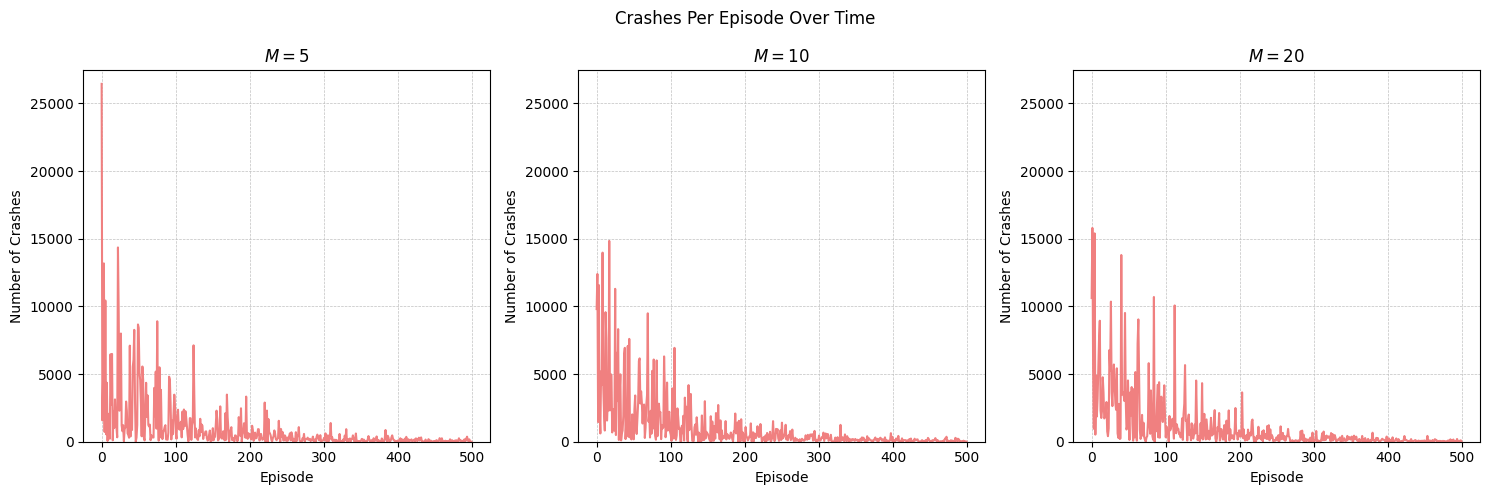

In [56]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Crashes Per Episode Over Time')

min_length = min(min(stats["episode_crashes"]) for stats in [stats_5, stats_10, stats_20])
max_length = max(max(stats["episode_crashes"]) for stats in [stats_5, stats_10, stats_20])

for i, (n_simulations, stats) in enumerate(zip([5, 10, 20], [stats_5, stats_10, stats_20])):
    ax = axes[i]

    ax.plot(stats["episode_crashes"], color="lightcoral")

    ax.set_title(f'$M={n_simulations}$')
    ax.grid(color='silver', linestyle='--', linewidth=0.5)
    ax.set(xlabel='Episode', ylabel='Number of Crashes')
    
    ax.set_ylim(min_length, max_length + 1000)

plt.tight_layout()
plt.show()